
# Spotify Song Recommender System


## Steps:
- K-means clustering to cluster songs based on audio features.
- Content-based filtering based on song features from similarity computation using cosine similarity.
- Collaborative filtering using matrix factorization.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

file_path = '../data/processed_spotify_songs.csv'
data = pd.read_csv(file_path)

In [2]:
data.head()

,track_artist,track_popularity,track_album_id,track_album_release_date,playlist_id,playlist_subgenre,danceability,energy,key,loudness,...,latin,rock,pop,artist_track_encoded,playlist_id_encoded,track_album_id_encoded,release_year,release_month,release_day,Cluster
0,Barbie's Cradle,41.0,1srJQ0njEQgd8w4XSqI4JQ,2001-01-01,37i9dQZF1DWYDQ8wBxd7xt,classic rock,0.481351,0.160801,2.0,0.588413,...,0,1,0,43.5,43.100000,41.0,2001,1,1,0
1,RIKA,15.0,1ficfUnZMaY1QkNp15Slzm,2018-01-26,0JmBB9HfrzDiZoPVRdv8ns,neo soul,0.350541,0.495616,5.0,0.715122,...,0,0,0,15.0,26.206186,15.0,2018,1,26,1
2,Steady Rollin,28.0,3z04Lb9Dsilqw68SHt6jLB,2017-11-21,3YouF0u7waJnolytf9JCXf,hard rock,0.095012,0.774400,9.0,0.768273,...,0,1,0,29.5,31.697917,28.0,2017,11,21,0
3,The.madpix.project,24.0,1Z4ANBVuhTlS6DprlP0m1q,2015-08-07,5TiiHps0hNCyQ6ijVkNZQs,electropop,0.449432,0.630436,10.0,0.736041,...,0,0,1,12.2,39.436364,24.0,2015,8,7,1
4,YOSA & TAAR,38.0,2BuYm9UcKvI0ydXs5JKwt0,2018-11-16,37i9dQZF1DXdOtZGKonFlM,dance pop,0.453533,0.702244,1.0,0.713109,...,0,0,1,38.0,35.673469,38.0,2018,11,16,0


#### a. K-means clustering

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
## Making sure that the data is normalized correctly to apply k-means

cluster_features = [
    'danceability', 'energy', 'key', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence',
    'tempo', 'artist_track_encoded', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock'
]

scaler = StandardScaler()
normalized_features = scaler.fit_transform(data[cluster_features])

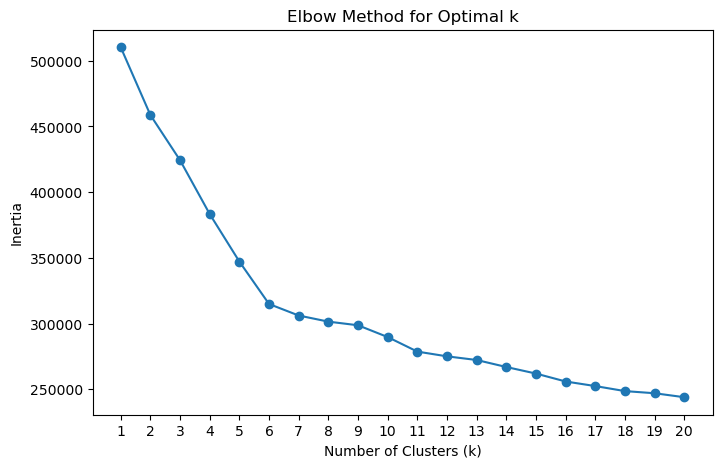

In [5]:
## Implementing the elbow method to find the optimal number of clusters

inertias = []
max_k = 20

for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_features)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_k + 1), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.xticks(range(1, max_k + 1))
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

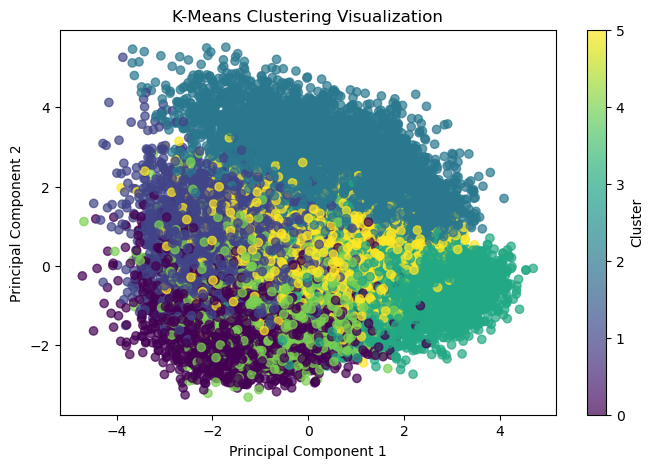

,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock,Cluster
0,Barbie's Cradle,classic rock,2001,0,0,0,0,0,1,2
1,RIKA,neo soul,2018,0,1,0,0,0,0,1
2,Steady Rollin,hard rock,2017,0,0,0,0,0,1,2
3,The.madpix.project,electropop,2015,0,0,0,0,1,0,5
4,YOSA & TAAR,dance pop,2018,0,0,0,0,1,0,5


In [6]:
## From the elbow plot, we observe that the optimal number of clusters is 6
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data_cluster = data.copy()
data_cluster['Cluster'] = kmeans.fit_predict(normalized_features)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(normalized_features)

plt.figure(figsize=(8, 5))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=data_cluster['Cluster'], cmap='viridis', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering Visualization')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Display cluster assignments for each song
data_cluster[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']].head()

Let us now try to interpret these clusters. Our hypothesis is that it clusters based off of genre, so let's plot that and compare.

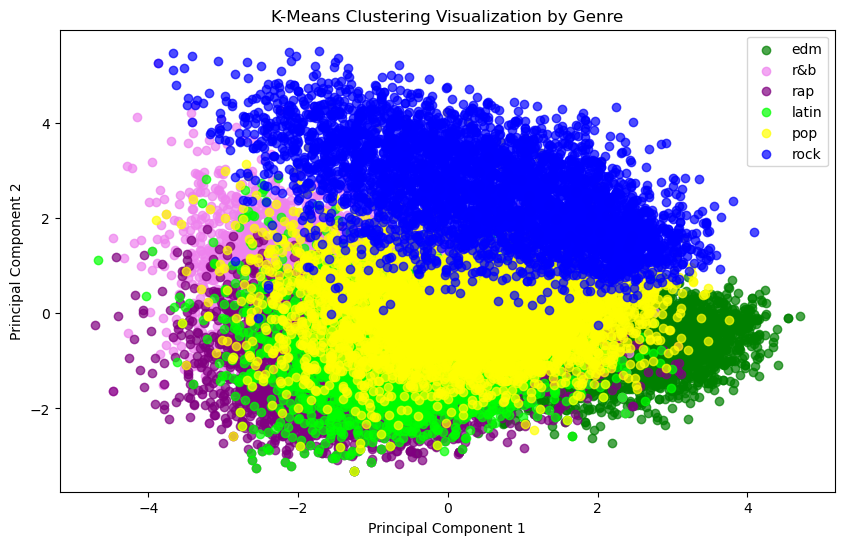

In [7]:
# Colouring in the clusters according to each genre
plt.subplots(figsize=(10, 6))
genres = ['edm', 'r&b', 'rap', 'latin', 'pop', 'rock']
colors = ['green', 'violet', 'purple', 'lime', 'yellow', 'blue']

for genre, color in zip(genres, colors):
    plt.scatter(reduced_features[data_cluster[genre] == 1, 0], reduced_features[data_cluster[genre] == 1, 1], c=color, label=genre, alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering Visualization by Genre')
plt.legend()
plt.show()

Comparing the two plots, we can see that the clusters are most likely based off of genre.

In [8]:
def recommend_songs_k_means(input_indices, data_cluster, normalized_features, num_recommendations=1):

    cluster_features = data_cluster['Cluster'].values.reshape(-1, 1)
    combined_features = np.hstack([normalized_features, cluster_features])

    input_song_features = combined_features[input_indices]

    similarities = cosine_similarity(input_song_features, combined_features)
    similarities = np.mean(similarities, axis=0)

    for idx in input_indices:   
        similarities[idx] = -1
        
    recommended_song_indices = np.argsort(similarities)[::-1][:num_recommendations]

    return data_cluster.iloc[recommended_song_indices]

In [9]:
input_indices = np.random.choice(data_cluster.shape[0], 3, replace=False)
print("Some of the input songs' features:")
data_cluster.iloc[input_indices][['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']]

Some of the input songs' features:


,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock,Cluster
21804,Sean C. Johnson,neo soul,2009,0,1,0,0,0,0,1
21899,Imagine Dragons,pop edm,2012,1,0,0,0,0,0,3
23467,Ioearth,album rock,2009,0,0,0,0,0,1,2


In [10]:
recommendations = recommend_songs_k_means(input_indices, data_cluster, normalized_features)
print("Recommended Songs:")
recommendations[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']]

Recommended Songs:


,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock,Cluster
651,Laidback Luke,progressive electro house,2015,1,0,0,0,0,0,3


#### b. Content-based filtering

In [11]:
## The features we want to influence the recommendation system
features = [
        'danceability', 'energy', 'key', 'loudness', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence',
        'tempo', 'artist_track_encoded', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock'
    ]

In [12]:
def recommend_songs_content_filter(input_indices, data, features, num_recommendations=1):
    feature_matrix = data[features].values
    input_features = feature_matrix[input_indices]
    avg_features = np.mean(input_features, axis=0).reshape(1, -1)
    
    similarities = cosine_similarity(avg_features, feature_matrix).flatten()
    similar_indices = np.argsort(similarities)[::-1]
    similar_indices = [idx for idx in similar_indices if idx not in input_indices][:num_recommendations]
    
    return data.iloc[similar_indices]

In [13]:
input_indices = np.random.choice(data.shape[0], 3, replace=False)
print("Some of the input songs' features:")
data.iloc[input_indices][['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock']]

Some of the input songs' features:


,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock
25789,El Pinche Mara,hip hop,2019,0,0,1,0,0,0
15879,Three 6 Mafia,southern hip hop,1995,0,0,1,0,0,0
569,DJ Khalid,tropical,2019,0,0,0,1,0,0


In [14]:
recommendations = recommend_songs_content_filter(input_indices, data, features)
print("Recommended Songs:")
recommendations[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock']]

Recommended Songs:


,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock
18996,Franklin Embry,southern hip hop,2014,0,0,1,0,0,0


Let us now figure out which features influence the recommendation system the most using a feature sensitivity analysis.

In [15]:
def analyze_feature_influence(input_songs, data, features, num_recommendations=1):

    ## Same as before for the next lines
    feature_matrix = data[features].values
    input_features = feature_matrix[input_songs]
    avg_features = np.mean(input_features, axis=0).reshape(1, -1)
    similarities = cosine_similarity(avg_features, feature_matrix).flatten()
    original_similar_indices = np.argsort(similarities)[::-1][:num_recommendations]

    feature_influence = []
    for i, feature in enumerate(features):
        perturbed_features = avg_features.copy()
        perturbed_features[0, i] += np.std(feature_matrix[:, i])

        new_similarities = cosine_similarity(perturbed_features, feature_matrix).flatten()
        new_similar_indices = np.argsort(new_similarities)[::-1][:num_recommendations]

        change_in_rank = len(set(original_similar_indices) - set(new_similar_indices))
        feature_influence.append((feature, change_in_rank))

    feature_influence.sort(key=lambda x: x[1], reverse=True)
    return pd.DataFrame(feature_influence, columns=["Feature", "Change in Rank"])

In [16]:
## We use the same features and input indices as before
feature_influence = analyze_feature_influence(input_indices, data, features, num_recommendations=5)
print(feature_influence)

                 Feature  Change in Rank
0                    key               5
1   artist_track_encoded               5
2                 energy               2
3                  tempo               2
4                  latin               2
5           danceability               1
6           acousticness               1
7               liveness               1
8                valence               1
9           release_year               1
10              loudness               0
11           speechiness               0
12      instrumentalness               0
13                   edm               0
14                   r&b               0
15                   rap               0
16                   pop               0
17                  rock               0


So we notice in this model that the genre is no longer the most important, but rather having similar audio features (key, energy, tempo etc.) and artist. 

However, we still notice that latin is pointed out as a relevant feature which might be coming from potential imbalance of the genres amongst our dataset. Let's check for that.

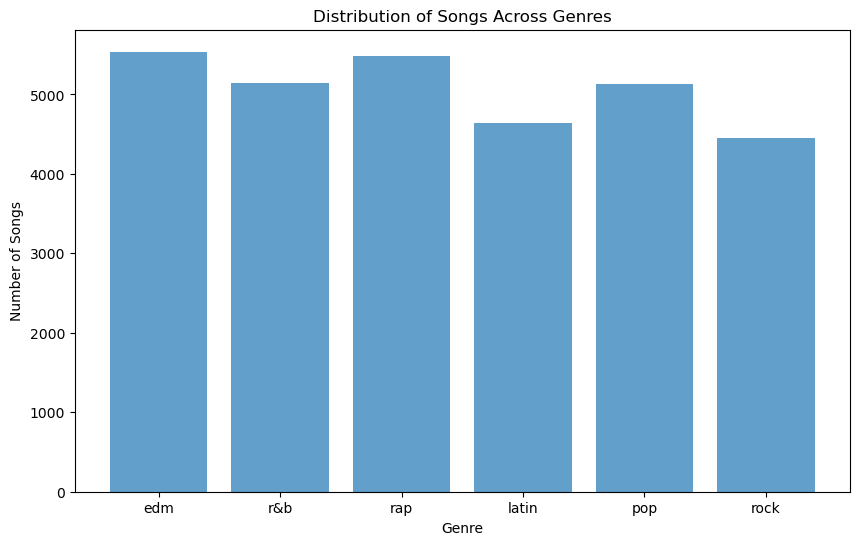

In [28]:
plt.figure(figsize=(10, 6))
genres = ['edm', 'r&b', 'rap', 'latin', 'pop', 'rock']

genre_counts = [data[genre].sum() for genre in genres]
plt.bar(genres, genre_counts, alpha=0.7)
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.title('Distribution of Songs Across Genres')
plt.show()

From the plot above, we don't notice particularly strong imbalance between the genres, especially not in favour of the latin genre... Our second hypothesis for why the latin genre tends to come out as an important feature is that it might be a much more distinct genre in terms of audio features (which we showed are the most influent features for the recommendation system) and thus it stands out as an important feature due to this correlation.

Furthermore, we remove 'loudness', 'speechiness', 'instrumentalness' from the analysis, because from above, they have an importance weight of 0.

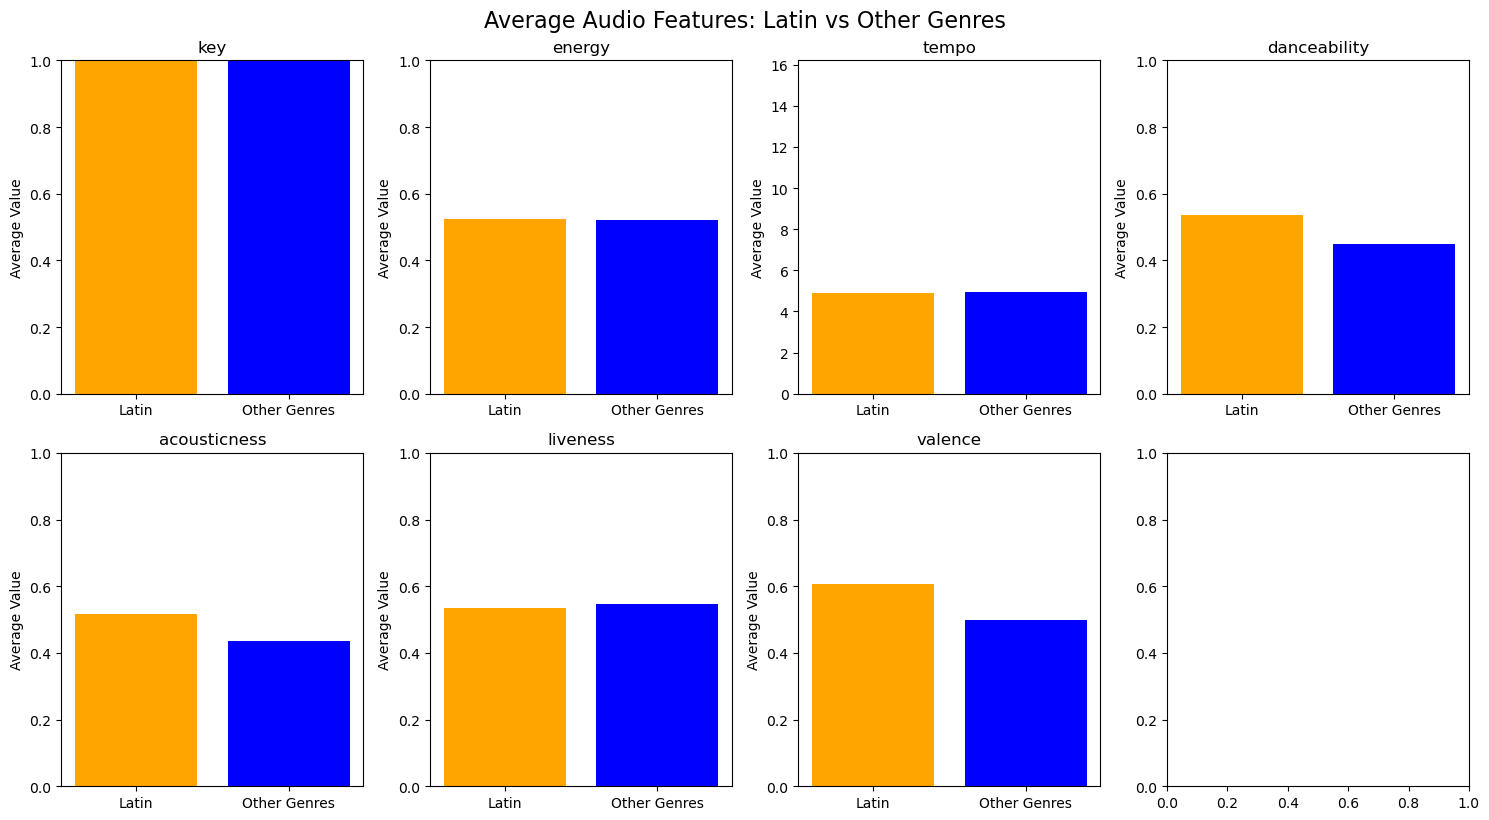

In [30]:
audio_features = [
    'key', 'energy', 'tempo', 'danceability', 'acousticness',
    'liveness', 'valence'
]

latin_avg = data[data['latin'] == 1][audio_features].mean()
non_latin_avg = data[data['latin'] == 0][audio_features].mean()

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()
for i, feature in enumerate(audio_features):
    axes[i].bar(['Latin', 'Other Genres'], [latin_avg[feature], non_latin_avg[feature]], color=['orange', 'blue'])
    axes[i].set_title(feature)
    axes[i].set_ylabel('Average Value')
    axes[i].set_ylim(0, 1 if feature != 'tempo' else data[feature].max() + 10)
plt.tight_layout()
plt.suptitle('Average Audio Features: Latin vs Other Genres', y=1.02, fontsize=16)
plt.show()

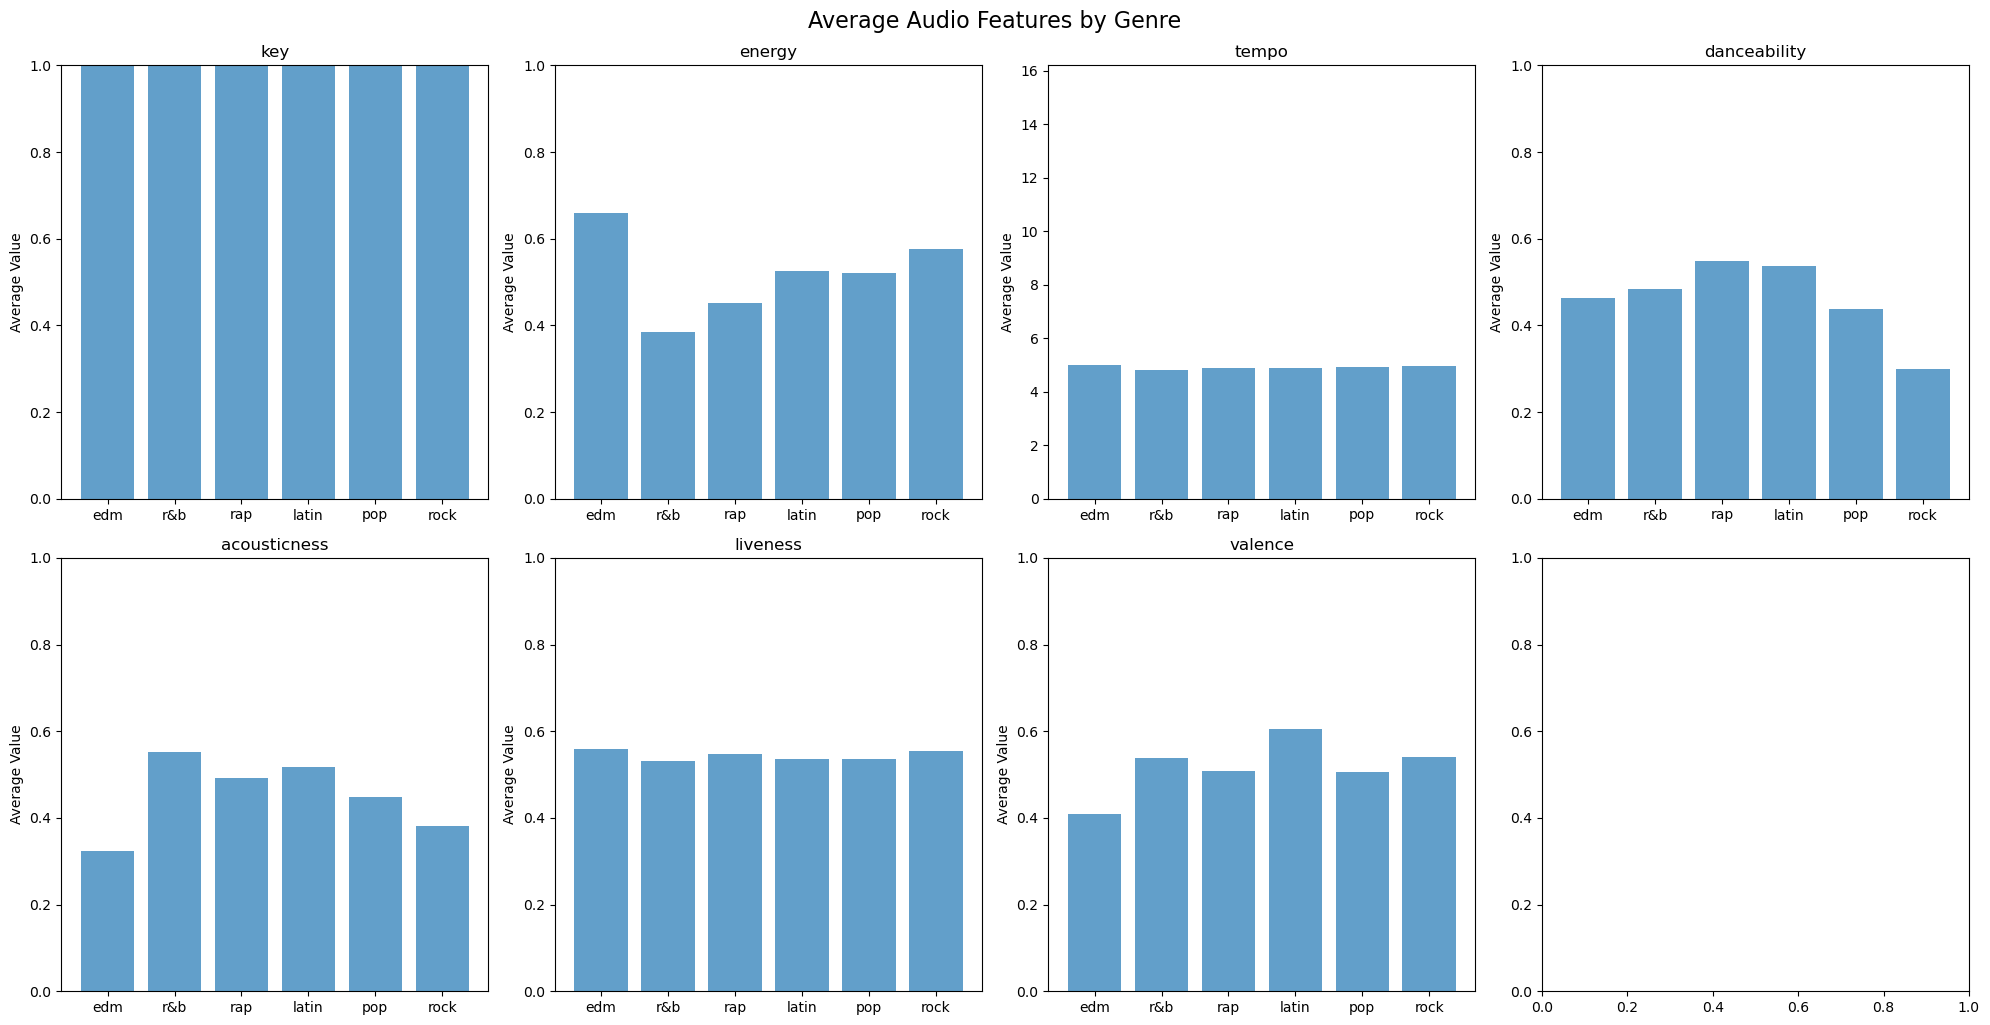

In [31]:
audio_features = [
    'key', 'energy', 'tempo', 'danceability', 'acousticness',
    'liveness', 'valence'
]
genres = ['edm', 'r&b', 'rap', 'latin', 'pop', 'rock']


genre_averages = {genre: data[data[genre] == 1][audio_features].mean() for genre in genres}
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()
for i, feature in enumerate(audio_features):
    feature_averages = [genre_averages[genre][feature] for genre in genres]
    axes[i].bar(genres, feature_averages, alpha=0.7)
    axes[i].set_title(feature)
    axes[i].set_ylabel('Average Value')
    axes[i].set_ylim(0, 1 if feature != 'tempo' else data[feature].max() + 10)
plt.tight_layout()
plt.suptitle('Average Audio Features by Genre', y=1.02, fontsize=16)
plt.show()

So we notice indeed that our second hypothesis might be correct, as the latin genre is more distinct in terms of danceability, acousticness and valence than when averaging the other genres! However, it does not consistently stand out and is still not the highest or lowest in terms of danceability and acousticness. Overall, it is a mix of these features that makes the latin genre stand out.

#### e. Comparison of models

In [17]:
input_indices = np.random.choice(data.shape[0], 3, replace=False)
print("Some of the input songs' features:")
data.iloc[input_indices][['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock']]

Some of the input songs' features:


,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock
18802,Sebastian Yatra,"latin pop, latin hip hop",2019,0,0,0,1,0,0
12788,Warrant,hard rock,1990,0,0,0,0,0,1
23119,Tommy Mc,"latin pop, big room",2020,1,0,0,1,0,0


In [18]:
data_cluster.iloc[input_indices][['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']]

,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock,Cluster
18802,Sebastian Yatra,"latin pop, latin hip hop",2019,0,0,0,1,0,0,4
12788,Warrant,hard rock,1990,0,0,0,0,0,1,2
23119,Tommy Mc,"latin pop, big room",2020,1,0,0,1,0,0,3


In [19]:
print('\n a. K-means clustering \n')
recommendations = recommend_songs_k_means(input_indices, data_cluster, normalized_features)
recommendations[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock', 'Cluster']]


 a. K-means clustering 



,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock,Cluster
20395,De La Ghetto,reggaeton,2006,0,0,0,1,0,0,4


In [21]:
print('\n b. Content-based filtering \n')
recommendations = recommend_songs_content_filter(input_indices, data, features)
recommendations[['track_artist', 'playlist_subgenre', 'release_year', 'edm', 'r&b', 'rap', 'latin', 'pop', 'rock']]


 b. Content-based filtering 



,track_artist,playlist_subgenre,release_year,edm,r&b,rap,latin,pop,rock
7646,José Lucas,tropical,2019,0,0,0,1,0,0


When comparing over some runs the performance of the two models, since the first one is based off of the song's genre, and the second one is based off of the song's audio features, we often have dissimilar recommendations. However, if in the input songs, there are some latin ones, then from our previous analysis of feature importance, they most often will both recommend a latin song!